# Workspace Setup

Here we have our desired libraries defined, which will allow us to generate the plots and graphs of our variants interactively. 

In [2]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel

This function is used to plot one or more histograms onto the same graph, given some data values x, axis label f and histogram-specific label(s) lab. The bins, neglim, and xlim determine the size of the window being considered and how many bins to store the data in, and the percents is used to draw vertical lines for user-specified percentile thresholds on the first input dataset.

Due to the percentile implementation, it's assumed the first input data set is the least filtered. 

In [3]:
def plot_variant_hist(x, f, bins=30, neglim=None, xlim=None, percents=[]):
    if neglim == None:
        neglim = min(x)
    if xlim == None:
        xlim = max(x)

    # Creates histogram with desired bins, window ranges, and labels. 
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=5)
    
    ax.hist(x, bins=bins, range=(neglim, xlim), rwidth=0.9)

    # Display dash percentile lines, along with legend labels
    if (percents):
        cs = ['b','g','r','c','m','y','k']
        for i in range(len(percents)):
            plt.axvline(np.percentile(x, percents[i]), color=cs[i % len(cs)], 
                        label=("%d%%" % percents[i]), linestyle='dashed')
        ax.legend()    

    ax.set_xlabel(f)
    ax.set_xlim(neglim, xlim)
    ax.set_ylabel('No. variants')
    ax.set_title('Variants over %s distribution' % f)
    return fig

```plot_multi_hist``` takes in an array of datasets x with a relevant name or general label f, then optional arguments for labeling individual sets, bin sizes, and window boundaries to display histograms side-by-side. The stacked option allows for histograms to be displayed either overlapping on the same column (when True) or side-by-side (when False). 

In [4]:
def plot_multi_hist(x, f, lab=None, bins=20, neglim=None, xlim=None, stacked=False):
    if neglim == None:
        neglim = min(x[0])
    if xlim == None:
        xlim = max(x[0])

        
    fig, ax = plt.subplots()
    sns.despine(ax=ax, offset=10)
    
    if (stacked):
        for i in range(len(x)):
            ax.hist(x[i], bins=bins, range=(neglim,xlim), rwidth=0.9, label=lab[i])
    else:
        ax.hist(x, bins=bins, range=(neglim, xlim), rwidth=0.9, label=lab, stacked=False)
    
    ax.set_xlabel(f)
    ax.set_xlim(neglim, xlim)
    ax.set_ylabel('No. variants')
    ax.set_title('Variants over %s distribution' % f)
    
    ax.legend()
    
    return fig

```plot_windowed_variant_density``` displays the density of variants along a chromosomal position, by aggregating variants within a given window size and sliding said window across the genome to determine a local average density. 

In [5]:
def plot_windowed_variant_density(pos, window_size, title=None):
    bins = np.arange(0, pos.max(), window_size)

    # setup windows 
    # bins = np.arange(0, pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2    

    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size

    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)
        
    return fig

```multi_windowed_variant_density``` displays several variant density plots alongside one another, using the same chromosomal position. This allows users to see how strongly filters affect particular positions along the genome. 

In [6]:
def multi_windowed_variant_density(pos, window_size, title=None):
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=5)
    
    for i in pos:
        # setup windows 
        # use window midpoints as x coordinate
        bins = np.arange(0, i.max(), window_size)
        x = (bins[1:] + bins[:-1])/2    
        
        # compute variant density in each window
        h, _ = np.histogram(i, bins=bins)
        y = h / window_size
        ax.plot(x, y)
        
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)
        
    return fig

This function will simply list some relevant distribution statistics numerically.

In [7]:
def summary_stats(x, f, low, high):
    avg = np.mean(x)
    dev = np.std(x)
    low_thresh = np.percentile(x, low)
    high_thresh = np.percentile(x, high)
    print("Given %d samples, we have the following stats for %s:\nMean: %f\
            \nSt. Deviation: %f\n%dth percentile: %f\n%dth percentile: %f\n"
          % (len(x), f, avg, dev, low, low_thresh, high, high_thresh))

These define our desired input and output files using their absolute paths, which are used for later dataset queries and optionally for file conversion. NOTE: If the vcf file is currently compressed, this notebook's kernel will likely die before it fully decompresses the file, so it's better to decompress any such files directly through a terminal or GUI before running the rest of the notebook. 

In [8]:
vcf_file = ""
h5_file = "/scratch/eld72413/SAM_seq/results2/VCF_results_new/Genotype_GVCFs/vcf_split_regions/Ha412HOChr06_61407150-79703556.h5"
pdf_file = ""
filtered_file = ""

# Conversion (Optional: See below)

Next we convert our .vcf file to an .hdf5 format to increase plotting and indexing speed (and thus, overall performance). For this we need a desired input .vcf file and then a target destination for our .hdf5 file. 

If the desired file is still compressed using gzip, use the following code snippet to decompress it:


In [ ]:
import gzip
import shutil
if '.gz' in vcf_file:
    with gzip.open(("%s.gz" % vcf_file), 'rb') as f_in:
        with open(vcf_file, 'wb') as f_out:
            print(f_in, f_out)
            shutil.copyfileobj(f_in, f_out)
else:
    print("VCF file is not compressed, proceed")

<b>NOTE:</b> Once the VCF file has been converted, the same HDF5 file can be reused for successive rounds of analysis and plotting. Thus, it is suggested to NOT re-run this code block unless working with an altered sample or otherwise different VCF file. 

In [ ]:
# Ideally executed once per project/file, then investigate with the rest of the notebook 
allel.vcf_to_hdf5(vcf_file,
                  h5_file,
                  fields='*',
                  overwrite=True)

# Plotting Workspace

We have encoded the VCF file to an hdf5 format, so now we need to access our hdf5 file and its data. Depending on the richness of the given VCF file, there will be several attributes that allow for filtering the variants, such as depth of read or inbreeding coefficients. First we'll show the top-level organization of the table, which is usually separated by either chromosome or data type (samples, variants, etc):

In [10]:
callset = h5py.File(h5_file, mode='r')
output = h5py.File('/scratch/eld72413/SAM_seq/results2/VCF_results_new/HC_Subset_Exploration/Ha412HOChr06_61407150Test.h5', mode='w')
print(list(callset))

['calldata', 'samples', 'variants']


Here we'll show all of the available attributes in the VCF file with the number of values in that field, as well as a sample variant entry:

In [11]:
print("Variant attributes (%d items):" % len(callset['variants']))
print("Attr.:\t Values:")
for i in callset['variants']:
    subset = callset['variants'][i]
    dim = 0
    if np.ndim(subset) == 1:
        dim = 1
    else:
        dim = np.shape(subset[0])[0]
    print(i, "\t", dim)

data = "\nFirst Variant:\n{"
for i in callset['variants']:
    data += ("%s : %s, " %(i, callset['variants'][i][0]))
data = data[:-2] + "}"
print(data)
print(np.shape([1]))

Variant attributes (31 items):
Attr.:	 Values:
AC 	 3
AF 	 3
ALT 	 3
AN 	 1
BaseQRankSum 	 1
CHROM 	 1
ClippingRankSum 	 1
DP 	 1
DS 	 1
END 	 1
ExcessHet 	 1
FILTER_LowQual 	 1
FILTER_PASS 	 1
FS 	 1
ID 	 1
InbreedingCoeff 	 1
MLEAC 	 3
MLEAF 	 3
MQ 	 1
MQRankSum 	 1
POS 	 1
QD 	 1
QUAL 	 1
RAW_MQ 	 1
RAW_MQandDP 	 2
REF 	 1
ReadPosRankSum 	 1
SOR 	 1
altlen 	 3
is_snp 	 1
numalt 	 1

First Variant:
{AC : [ 1 -1 -1], AF : [0.006329      nan      nan], ALT : ['T' '' ''], AN : 158, BaseQRankSum : -0.967, CHROM : Ha412HOChr06, ClippingRankSum : 0.0, DP : 110, DS : False, END : -1, ExcessHet : 3.0103, FILTER_LowQual : False, FILTER_PASS : False, FS : 0.0, ID : ., InbreedingCoeff : -0.1462, MLEAC : [ 4 -1 -1], MLEAF : [0.025   nan   nan], MQ : 24.49, MQRankSum : -0.967, POS : 61415498, QD : 11.16, QUAL : 33.47, RAW_MQ : 2400.0, RAW_MQandDP : [-1 -1], REF : G, ReadPosRankSum : -0.967, SOR : 0.223, altlen : [0 0 0], is_snp : True, numalt : 1}
(1,)


There may also be additional data in adjacent tables, such as 'calldata', which can include genotyping or other information corresponding to the individual samples and their variants. In the example VCF file, we have the following attributes:

In [12]:
print("\nOther attributes (%d items):" % len(callset['calldata']))
print("Attr.: \t Shape:")
for i in callset['calldata']:
    print("%s\t" % i, np.shape(callset['calldata'][i][0]))


Other attributes (11 items):
Attr.: 	 Shape:
AD	 (288, 4)
DP	 (288,)
GQ	 (288,)
GT	 (288, 2)
MIN_DP	 (288,)
PGT	 (288,)
PID	 (288,)
PL	 (288, 3)
PS	 (288,)
RGQ	 (288,)
SB	 (288, 4)


Here we have an example variant table defined, but the names list can be edited to include or exclude any desired attributes. Later we will use these attribute names to call upon the data columnwise, rather than row-wise with each individual variant's record. 

In [13]:
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'DP', 'MQ', 'QD', 'AC', 'FS', 'ReadPosRankSum', 'MQRankSum','ExcessHet'])
#variants = allel.VariantChunkedTable(callset['variants'])

Next we can plot the SNP densities over our variant data, given some desired aggregating window size. Here we show the variant density over chromosomal position without regard for chromosomes. This means that variants from different chromosomes will be mapped together, as long as their own chromosomal positions are similar. This may not be helpful for genomic data with partitioned chromosomes (see example below) or for examining specific chromosomes but it can help to illustrate general trends in variant mapping (i.e. where in a chromosome they tend to occur in a population).

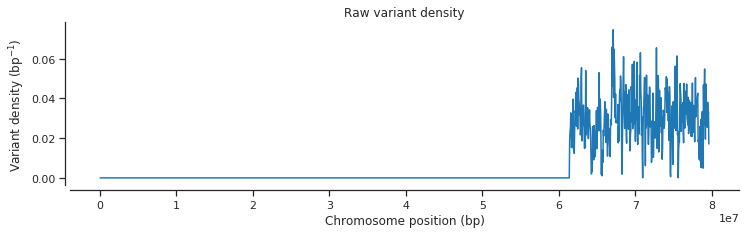

In [14]:
total_raw_dense = plot_windowed_variant_density(variants['POS'][:], window_size=50000, title='Raw variant density')

Depending on how the underlying VCF file is formatted, there may be more than one tag for each chromosome (e.g. chr1H_part1, chr1H_part2, etc). However, we can simply look for each unique chromosome tag here and plot each of them along the chromosomal position, thus avoiding the effects of improperly overlapping chromosomal regions. This can, however, take a while depending on the number of chromosomes and scaffolds found in the raw data.

In [15]:
#variants_chrom = variants.query('(CHROM==chr1H_part1)')
labs = np.unique(variants['CHROM'])
print('Number of graphs to be generated: ', len(labs))
for i in labs:
    print('(CHROM == "%s")' % i)
    variants_chrom = variants.query('(CHROM == "%s")' % i)
    # Here we create a local variable with the appropriate name and value pair
    name = ("%s_raw_dense" % i)
    locals()[name] = plot_windowed_variant_density(variants_chrom['POS'][:], window_size=50000, title=('%s Variant Density' % i))
    plt.show()


Number of graphs to be generated:  1
(CHROM == "Ha412HOChr06")


ValueError: missing object_codec for object array

Then display the summary stats of the read depth across all samples (DP), and display a histogram of the number of variants with a given read depth (placed into 'bins' number of bins). We can also define a list of percent thresholds we'd want displayed within the plot. The read depth could be limited based upon the context and scale of the data, but we have specified defaults here. 

Given 553571 samples, we have the following stats for DP:
Mean: 2243.543715            
St. Deviation: 816.644713
5th percentile: 556.000000
95th percentile: 3286.000000



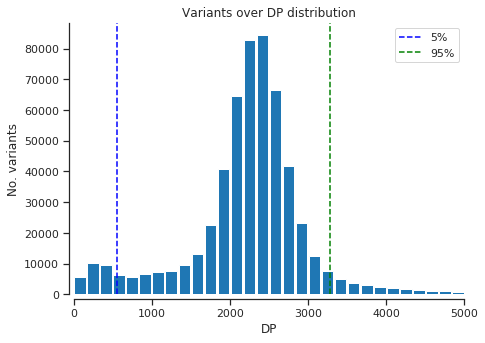

In [16]:
dp_set = variants['DP'][:]
dp_raw_plot = plot_variant_hist(dp_set, 'DP', neglim=-1, xlim=5000, percents=[5,95])
summary_stats(dp_set, 'DP', 5, 95)

Same idea here but for QUAL scores into bins. QUAL scores (and the normalized version, QD) express the confidence that any variation exists at a given site. 

Given 553571 samples, we have the following stats for QUAL:
Mean: 3495.563965            
St. Deviation: 13157.578125
5th percentile: 41.115000
95th percentile: 13532.385254



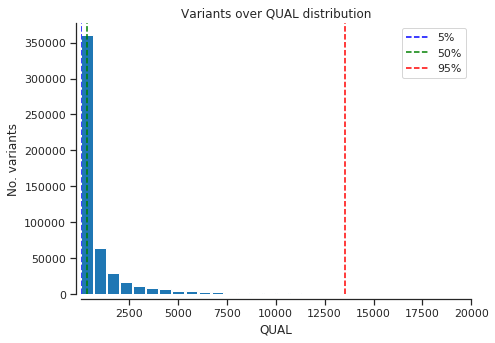

In [17]:
data_qual = variants['QUAL'][:]
summary_stats(data_qual, 'QUAL', 5, 95)
qual_raw_plot = plot_variant_hist(data_qual, 'QUAL', xlim=20000, percents=[5,50,95])

Same idea here but for Quality by Depth. For GATK, this is generated by calling the QUAL score and dividing it by the allele depth (AD), thus normalizing by the depth of reads supporting said variant such that high coverage with weakly supported reads count for less than low coverage with strongly supported reads. 

Given 553541 samples, we have the following stats for cleanQD:
Mean: 17.428719            
St. Deviation: 11.720453
5th percentile: 2.130000
95th percentile: 33.860001



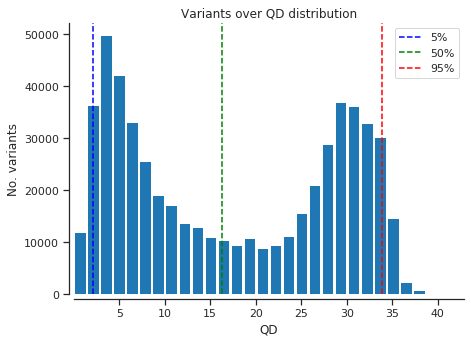

In [18]:
# With the GATK libraries, there are rarely (0.00001%) cases of infinite QD. Not sure why yet.
QD = variants['QD'][:]
cleanQD = QD[np.isfinite(QD)]
summary_stats(cleanQD, 'cleanQD', 5, 95)
qd_raw_plot = plot_variant_hist(cleanQD, 'QD', percents=[5, 50, 95])

Same idea here but for Genotyping Quality (GQ). GQ is calculated by GATK as the difference between the second lowest Phred-scaled likelihood of a genotype and the lowest likelihood, which is by convention 0 (further explanation of GATK conventions [here](https://software.broadinstitute.org/gatk/documentation/article?id=11075)). Furthermore, as it's calculated per sample, we can either flatten it to graph frequency across all samples or we can index so that we graph one sample's GQ (i.e. Sample A's GQ histogram across all variants, Sample B's histogram, etc.)

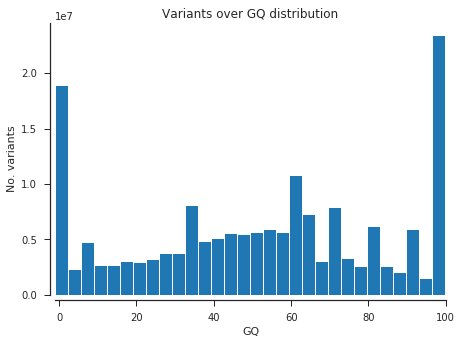

In [24]:
gq = callset['calldata/GQ']
gq_flat = callset['calldata/GQ'][:,:].flatten()
gq_raw_plot = plot_variant_hist(gq_flat, 'GQ', bins=30, xlim=100)

# Filtering and Analysis

Below we see an example filtering expression, along with both a query and compression example, in order to determine high vs low quality variants. The query method is less useful when using data outside of the variants chunked table (i.e. one might lose genotyping information), but is more concise when all of the necessary data is present. 

In [25]:
filter_expr_strong = '(QD > 30) & (MQ > 4) & (DP > 5) & (DP < 3000)'
filter_expr_weak = '(QD > 10) & (MQ > 2) & (DP > 2) & (DP < 5000)'

# Here we filter using a simple query command, which is less extendible but more compact
variants_pass_strong = variants.query(filter_expr_strong)

# Here we filter using an evaluation of the above expression, then keep only
# those variants which satisfy said expression. This method can be extended
# to variant data stored elsewhere, assuming the ordering is the same. 
filter_weak = variants.eval(filter_expr_weak)
variants_pass_weak = variants.compress(filter_weak)

# How many variants remain within each group. 
print("Strongly filtered variants: %d" % len(variants_pass_strong))
print("Weakly filtered variants: %d" % len(variants_pass_weak))
print("Raw variants: %d" % len(variants))

<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarnin

Strongly filtered variants: 1734642
Weakly filtered variants: 3874860
Raw variants: 5622782


Now we can create the same plots as before, but with the newly filtered variants. We can also place these variants side-by-side using our methods from above. For example, if we plotted the variant density along the chromosome, we could get the following: 

We can also plot filtered datasets alone on a graph, such as below as a histogram, according to a desired attribute. 

Given 1734642 samples, we have the following stats for DP:
Mean: 1806.592578            
St. Deviation: 566.646081
5th percentile: 614.000000
95th percentile: 2502.000000



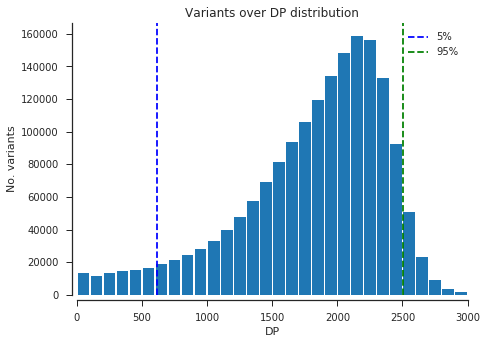

In [26]:
dp_set_s = variants_pass_strong['DP'][:]
summary_stats(dp_set_s, 'DP', 5, 95)
dp_strong_plot = plot_variant_hist(dp_set_s, 'DP', neglim=0, xlim=3000, percents=[5,95])

We may also want to compare the attributes of differently filtered datasets, displaying the histogram bars either side by side for each bin...

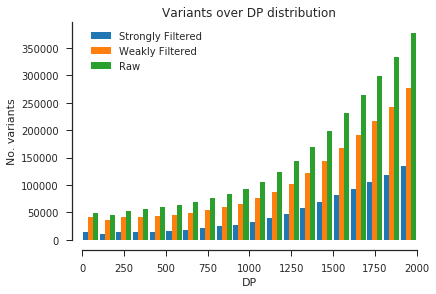

In [27]:
dp_set_w = variants_pass_weak['DP'][:]
dp_multi_plot = plot_multi_hist(np.array([dp_set_s, dp_set_w, dp_set]),'DP', neglim=-1,xlim=2000, 
                lab=['Strongly Filtered', 'Weakly Filtered', 'Raw'], stacked=False)

...or alternatively we can also show the bars as overlapping, for a more direct and compact comparison. NOTE: In order for the plot to display properly, one must list the datasets and their corresponding labels from most general (or least filtered) to least general. Otherwise the less general datasets are hidden behind the more general one(s). 

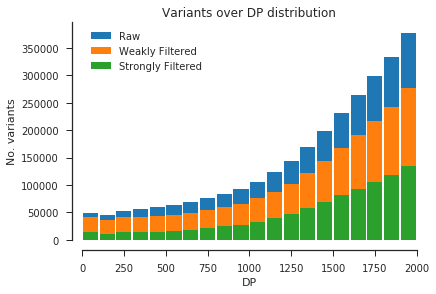

In [28]:
dp_multi_stacked = plot_multi_hist(np.array([dp_set, dp_set_w, dp_set_s]),'DP', neglim=-1,xlim=2000, 
                lab=['Raw', 'Weakly Filtered', 'Strongly Filtered'], stacked=True)

Given 1734642 samples, we have the following stats for QUAL:
Mean: 30183.507812            
St. Deviation: 23127.277344
5th percentile: 1333.479980
95th percentile: 74175.296875



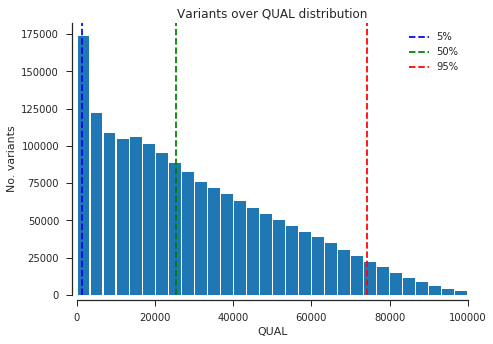

In [29]:
data_qual_s = variants_pass_strong['QUAL'][:]
summary_stats(data_qual_s, 'QUAL', 5, 95)

qual_strong_plot = plot_variant_hist(data_qual_s, 'QUAL', xlim=100000, percents=[5,50,95])

Given 1734642 samples, we have the following stats for cleanQD_s:
Mean: 32.497646            
St. Deviation: 1.755690
5th percentile: 30.209999
95th percentile: 35.610001



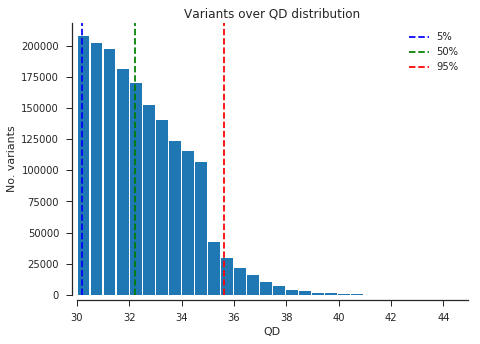

In [30]:
# With the GATK libraries, there are rarely cases of nan QD. Not sure why yet.
QD_s = variants_pass_strong['QD'][:]
cleanQD_s = QD_s[np.isfinite(QD_s)]
summary_stats(cleanQD_s, 'cleanQD_s', 5, 95)

qd_strong_plot = plot_variant_hist(cleanQD_s, 'QD', percents=[5, 50, 95])

Given 3874860 samples, we have the following stats for cleanQD_w:
Mean: 28.319792            
St. Deviation: 5.664574
5th percentile: 14.200000
95th percentile: 34.720001



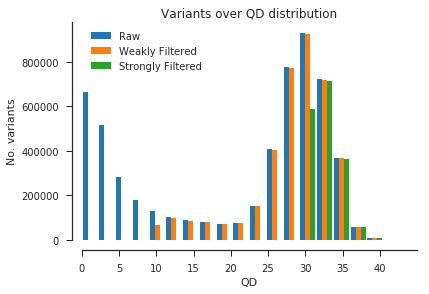

In [31]:
QD_w = variants_pass_weak['QD'][:]
cleanQD_w = QD_w[np.isfinite(QD_w)]
summary_stats(cleanQD_w, 'cleanQD_w', 5, 95)

qd_multi_plot = plot_multi_hist([cleanQD, cleanQD_w, cleanQD_s], 'QD', 
                lab=['Raw', 'Weakly Filtered', 'Strongly Filtered'])

# Ti/Tv Checking

Another helpful statistic to keep in mind for quality control is the ratio of transition to transversion mutations. Using pure chance we would expect relatively fewer transitions (a ratio of about 0.5), but the relevant mutation bias depends upon the organism being studied. Here we create an array of pairs with the reference and primary alternative alleles to help calculate the ratio. 

In [ ]:
mutations = np.array(variants['REF'] + variants['ALT'][:,0]).astype(str)

Then we use several functions to check if they are transitions (Ti), what the relative Ti/Tv value of a set of variants is, and to plot the Ti/Tv values against variant attribute values. 

In [ ]:
# If the reference and alternative alleles match the following patterns,
# then they are transitions. Otherwise they're transversions. 
def locate_transitions(x):
    x = np.asarray(x)
    return (x == 'AG') | (x == 'GA') | (x == 'CT') | (x == 'TC')

def ti_tv(x):
    if len(x) == 0:
        return np.nan
    is_ti = locate_transitions(x)
    n_ti = np.count_nonzero(is_ti)
    n_tv = np.count_nonzero(~is_ti)
    if n_tv > 0:
        return n_ti / n_tv
    else:
        return np.nan

# Here we can take every 'downsample' Ti/Tv value, in order to 
# lighten the computational load
def plot_ti_tv(f, downsample, bins):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    x = variants[f][:][::downsample]
    
    # plot an attribute's histogram
    ax.hist(x, edgecolor='black', bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')

    # plot Ti/Tv
    ax = ax.twinx()
    sns.despine(ax=ax, bottom=True, left=True, right=False, offset=10)
    values = mutations[::downsample]
    with np.errstate(over='ignore'):
        # binned_statistic generates an annoying overflow warning which we can ignore
        y1, _, _ = scipy.stats.binned_statistic(x, values, statistic=ti_tv, bins=bins)
    bx = (bins[1:] + bins[:-1]) / 2
    ax.plot(bx, y1, color='k')
    ax.set_ylabel('Ti/Tv')
    # ax.set_ylim(0.6, 1.3)

    ax.set_title('Variant %s and Ti/Tv' % f)
    
    return fig

In [ ]:
# Ti/Tv over all variants
ti_tv(mutations)

In [ ]:
# Some examples of plotting Ti/Tv against variant attributes
qd_ti_tv = plot_ti_tv('QD', 1, np.arange(0,40,1))
mq_ti_tv = plot_ti_tv('MQ', 1, np.arange(0,60,1))
dp_ti_tv = plot_ti_tv('DP', 1, np.linspace(0,5000,50))

# Relating seperate tables' data

Here we setup data from a different part of our callset, namely the calldata and its genotype ('GT') column. The GT is represented by 21 samples' genotyping for the diploid data for barley, resulting in [numVariants] x [numSamples] x [ploidy] data shape. We can, however, compress the genotypes for desired variants using our filtering evaluation from the above section (referring to [here](#Filtering-and-Analysis)), thus allowing us to pare down the investigated space significantly.

In [32]:
calldata = callset['calldata']
genotypes = allel.GenotypeChunkedArray(calldata['GT'])

# Optionally pull in sample metadata as a table
# samples_fn = ''
# samples = pandas.DataFrame.from_csv(samples_fn, sep='\t')
# sample_selection = samples.[FilteringAttr].isin([Dict of desired values]).values
# samples_subset = samples[sample_selection]

# Filter our genotype list down using our previous filter
variant_selection = variants.eval(filter_expr_strong)[:]
genotypes_subset = genotypes.subset(variant_selection)

<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarnin

Computes the missingness and heterozygosity for each sample, using both the raw and filtered variants. 

In [33]:
n_variants = len(variants_pass_strong)
n_variants_raw = len(variants)

# Counts what percent of each set has missing genotypes
pc_missing_raw = genotypes.count_missing(axis=0)[:] * 100 / n_variants_raw
pc_missing = genotypes_subset.count_missing(axis=0)[:] * 100 / n_variants

# Counts what percent of each set is heterozygously genotyped
pc_het_raw = genotypes.count_het(axis=0)[:] * 100 / n_variants_raw
pc_het = genotypes_subset.count_het(axis=0)[:] * 100 / n_variants
print("Raw missingniess: %s\n\n" % pc_missing_raw, "Filtered missingness: %s\n\n" % pc_missing, 
      "Raw heterozygosity: %s\n\n" % pc_het_raw, "Filtered heterozygosity: %s\n\n" % pc_het)

Raw missingniess: [5.31183674 3.90537993 4.9108075  4.70005773 4.42055196 4.94203759
 4.95528726 4.89497903 4.89435657 4.74537338 4.6653596  4.91046959
 4.90399592 6.38224993 6.02308608 6.2464097  6.93670855 6.60681848
 5.73241146 6.26389214 6.14757961 6.25594234 6.49847353 6.20851031
 5.97248835 5.80577373 6.31297817 4.93449684 5.02920085 4.99754392]

 Filtered missingness: [5.76337942 4.05380476 5.06421498 4.8570829  4.45163901 5.13166406
 5.14071491 5.08583327 5.08790863 4.90585377 4.67779519 4.91646115
 5.31608251 6.07312633 5.72094991 6.05635053 6.88015164 6.27466647
 5.69420088 6.0319651  5.8492761  6.30285673 6.40472213 5.88645957
 5.78909077 5.6625517  6.12547142 4.94130777 4.98431377 4.93525465]

 Raw heterozygosity: [28.0829134  18.05150902 10.86816099 11.25421544 11.7956556  10.97302012
 10.93385801 11.03066062 10.97563448 11.16187681 11.80282287 11.13799183
 17.12693112 10.39170645 11.32377176 10.52690643  8.73076708 10.49599647
 10.60604875 10.54173895 10.93896224 10.45423

Plots and compares statistics of each sample within either one set or multiple sets (such as after filtering variants). 

In [63]:
def plot_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    left = np.arange(len(pc))
    palette = sns.color_palette()

    ax.bar(left, pc, color=palette[0])
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)

    print(fig)
    return fig

In [66]:
def multi_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    palette = sns.color_palette()
    left = np.arange(len(pc[0]))
    labels = []
    
#   ax.bar(left, pc)
    for i in range(len(pc)):
        ax.bar(left, pc[i], color=palette[i])
        if (i == 0):
            labels.append('Raw')
        else: 
            labels.append('Filtered subset %d' % i)
    ax.set_xlim(0, len(pc[0]))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)
    ax.legend(labels=labels)
    
    return fig

Here we plot the missingness data for the raw variants alongside the filtered variants. 

Figure(864x288)
Figure(864x288)


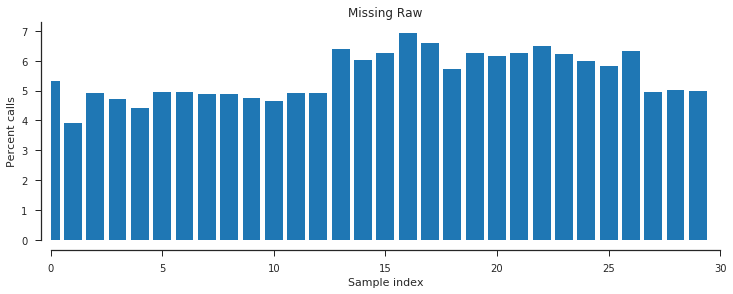

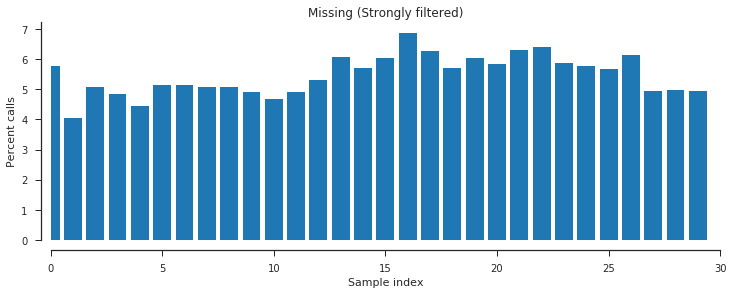

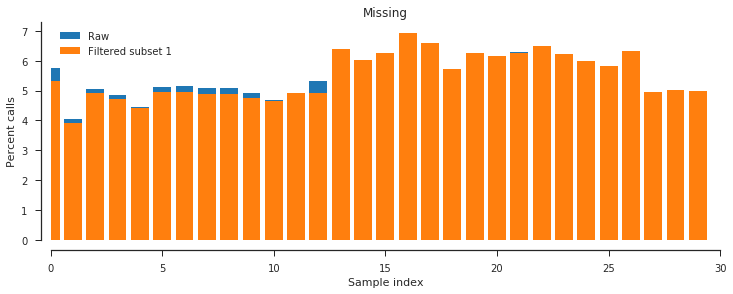

In [67]:
miss_raw_plot = plot_genotype_frequency(pc_missing_raw, 'Missing Raw')
miss_strong_plot = plot_genotype_frequency(pc_missing, 'Missing (Strongly filtered)')
miss_multi_plot = multi_genotype_frequency([pc_missing, pc_missing_raw], 'Missing')

Here we plot heterozygosity of samples from the raw variants

Figure(864x288)
Figure(864x288)


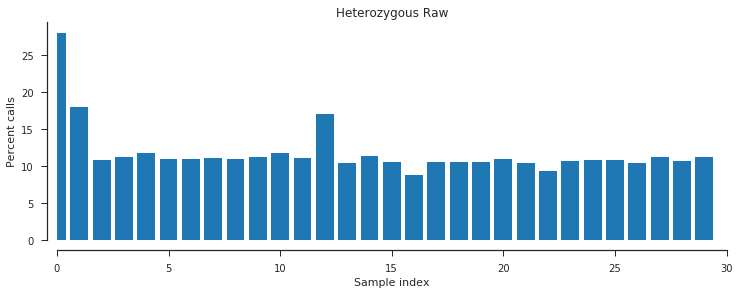

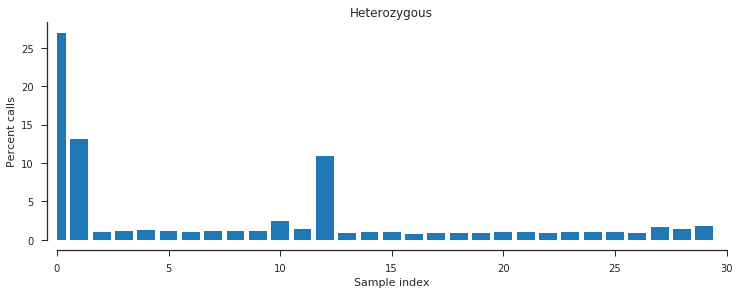

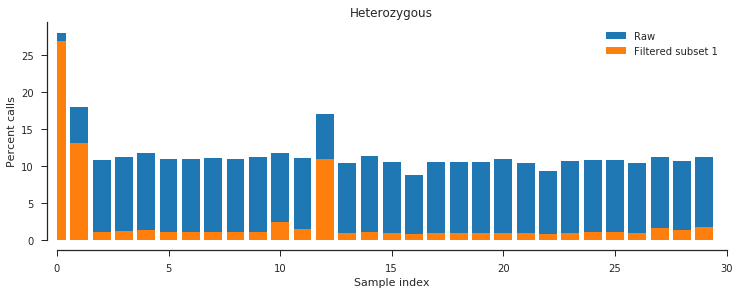

In [68]:
het_raw_plot = plot_genotype_frequency(pc_het_raw, 'Heterozygous Raw')
het_strong_plot = plot_genotype_frequency(pc_het, 'Heterozygous')
het_multi_plot = multi_genotype_frequency([pc_het_raw, pc_het], 'Heterozygous')

In [69]:
v_het = variants.query("(ExcessHet > 40)")
het_filter = variants.eval("(ExcessHet > 30)")
v_susp = variants.query("(ExcessHet > 20)")

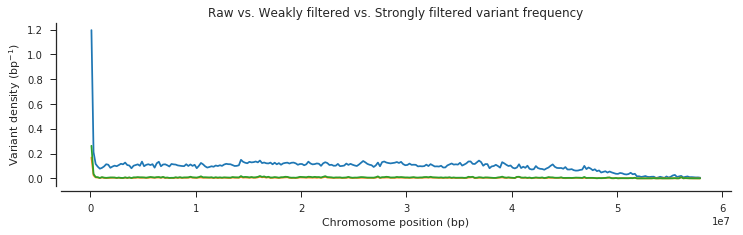

In [70]:
het_multi_dense = multi_windowed_variant_density([variants['POS'][:], v_het['POS'][:], v_susp['POS'][:]], 200000, 
                               title='Raw vs. Weakly filtered vs. Strongly filtered variant frequency')

# Graphical Output

The final step here is to print each of the saved plots into a pdf file, as specified at the beginning with a PDF filepath.

In [106]:
pp = PdfPages(pdf_file)
for i in locals():
    if isinstance(eval(i), mpl.figure.Figure):
        print('Saving figure', i)
        pp.savefig(eval(i), bbox_inches='tight')
pp.close()
print('Done saving to PDF at', pdf_file)

Saving figure total_raw_dense
Saving figure dp_raw_plot
Saving figure qual_raw_plot
Saving figure qd_raw_plot
Saving figure gq_raw_plot
Saving figure dp_strong_plot
Saving figure dp_multi_plot
Saving figure dp_multi_stacked
Saving figure qual_strong_plot
Saving figure qd_strong_plot
Saving figure qd_multi_plot
Saving figure miss_raw_plot
Saving figure miss_strong_plot
Saving figure miss_multi_plot
Saving figure het_raw_plot
Saving figure het_strong_plot
Saving figure het_multi_plot
Saving figure het_multi_dense
Saving figure temp
Saving figure Chr01_raw_dense
Saving figure Chr02_raw_dense
Saving figure Chr03_raw_dense
Saving figure Chr04_raw_dense
Saving figure Chr05_raw_dense
Saving figure Chr06_raw_dense
Saving figure Chr07_raw_dense
Saving figure Chr08_raw_dense
Saving figure Chr09_raw_dense
Done saving to PDF at %s. /panfs/roc/groups/9/morrellp/haman152/Example/FN30CAT_30.pdf


# Write to new VCF file

We should now be able to use all of our filters in unison to provide us with our final desired variants. Once that's done, use the scikit-allel's library to write out the data to a VCF file:

In [124]:
print(het_filter[:])
print(filter_weak[:])
final_filter = het_filter * filter_weak 
print(final_filter[:])
# print(sum(het_filter), sum(filter_weak), sum(final_filter))
print(np.count_nonzero(het_filter[:]), np.count_nonzero(filter_weak[:]), np.count_nonzero(final_filter[:]))

[ True False  True ... False False False]
[False False False ...  True  True False]
[False False False ... False False False]
351605 3874860 136106


In [153]:
final_v = variants.compress(final_filter)
final_g = callset['calldata'].compress(final_filter, axis=0)
print(np.shape(final_v), np.shape(final_g))

AttributeError: 'Group' object has no attribute 'compress'

In [ ]:
callset.copy(callset['calldata'], output)

In [174]:
cdata = callset['calldata']
print(list(cdata))
print(np.shape(cdata))
gt_data = allel.GenotypeChunkedArray(cdata['GT'])
final_g = gt_data.compress(final_filter)
print(np.shape(gt_data))
print(np.shape(final_g))
print(np.shape(final_v))
for i in cdata:
    cdata[i] = (allel.GenotypeChunkedArray(cdata[i])).compress(final_filter)

['AD', 'DP', 'GQ', 'GT', 'MIN_DP', 'PGT', 'PID', 'PL', 'RGQ', 'SB']
(10,)
(5622782, 30, 2)
(136106, 30, 2)
(136106,)


ValueError: Unable to create dataset (no write intent on file)

NOTE: Write_vcf appears to be 

In [128]:
allel.write_vcf(filtered_file, final_v)

In [129]:
print('Done!')

Done!


In [132]:
print(list(final_v.keys()))

['AC', 'ALT', 'CHROM', 'DP', 'ExcessHet', 'FS', 'MQ', 'MQRankSum', 'POS', 'QD', 'QUAL', 'REF', 'ReadPosRankSum']
